
# Techniques Avancées d'apprentissage

In [64]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import utils.mnist_reader as mnist_reader
import utils.tools as tls
import PIL.Image

In [83]:
# Load the dataset
X_train, y_train = mnist_reader.load_mnist('./data', kind='train')
X_test, y_test = mnist_reader.load_mnist('./data', kind='t10k')
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (60000, 784)
Shape of y_train:  (60000,)
Shape of X_test:  (10000, 784)
Shape of y_test:  (10000,)


In [91]:
label_dic = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 
             5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

* Two ways to visualise the images

In [81]:
# Method 1
PIL.Image.fromarray(X_train.reshape((X_train.shape[0],28,28))[0])
#tls.save_image("./mnist/visualization/sample.png", X_train[0]) to save

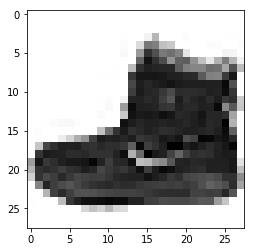

In [101]:
# Method 2
plt.imshow(X_train.reshape((X_train.shape[0],28,28))[0], cmap=plt.cm.binary)

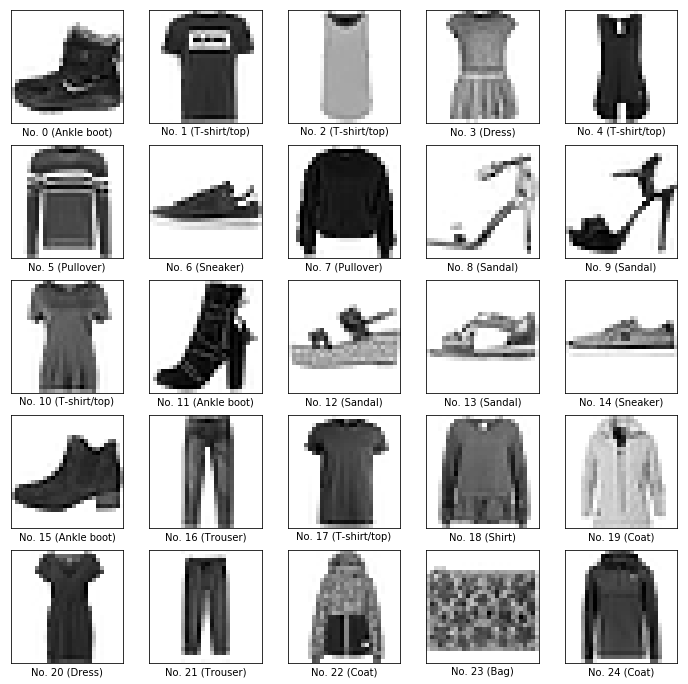

In [105]:
plt.figure(figsize=(12,12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("No. %d (%s)" %(i, label_dic[y_train[i]]))
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)

In [ ]:
# To check if we need to normalise the data into 0-1 range just like Neural Network.
# X_train = X_train / 255.0